# Libraries

In [1]:
import gdown
import requests

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor

from xgboost import XGBRegressor

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR

# Phase 1: Data Preparation & Time Series Exploration

## 1.1 Load and Inspect Dataset

* Download dataset

In [3]:
file_id = "1pzZRdhN50kJiMQhkerOPKXW7FVfAgCOs"
url = f"https://drive.google.com/uc?id={file_id}"

gdown.download(url, "household_power_consumption.txt", quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=1pzZRdhN50kJiMQhkerOPKXW7FVfAgCOs
From (redirected): https://drive.google.com/uc?id=1pzZRdhN50kJiMQhkerOPKXW7FVfAgCOs&confirm=t&uuid=9b3bdec7-b49f-41b5-962e-a000088a9e54
To: /content/household_power_consumption.txt
100%|██████████| 133M/133M [00:01<00:00, 79.3MB/s]


'household_power_consumption.txt'

* Read dataset

In [4]:
df = pd.read_csv("household_power_consumption.txt",
                 sep=';',
                 parse_dates=[[0, 1]],
                 na_values='?',
                 infer_datetime_format=True,
                 low_memory=False)

df.columns = ['Datetime', 'Global_active_power', 'Global_reactive_power',
              'Voltage', 'Global_intensity', 'Sub_metering_1',
              'Sub_metering_2', 'Sub_metering_3']

df.head()

/tmp/ipython-input-691409927.py:1: FutureWarning: Support for nested sequences for 'parse_dates' in pd.read_csv is deprecated. Combine the desired columns with pd.to_datetime after parsing instead.
  df = pd.read_csv("household_power_consumption.txt",
/tmp/ipython-input-691409927.py:1: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df = pd.read_csv("household_power_consumption.txt",
/tmp/ipython-input-691409927.py:1: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df = pd.read_csv("household_power_consumption.txt",


,Datetime,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
1,2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2,2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
3,2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
4,2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0


* Data inspection



In [5]:
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075259 entries, 0 to 2075258
Data columns (total 8 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   Datetime               datetime64[ns]
 1   Global_active_power    float64       
 2   Global_reactive_power  float64       
 3   Voltage                float64       
 4   Global_intensity       float64       
 5   Sub_metering_1         float64       
 6   Sub_metering_2         float64       
 7   Sub_metering_3         float64       
dtypes: datetime64[ns](1), float64(7)
memory usage: 126.7 MB


,Datetime,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
count,2075259,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06
mean,2008-12-06 07:12:59.999994112,1.091615e+00,1.237145e-01,2.408399e+02,4.627759e+00,1.121923e+00,1.298520e+00,6.458447e+00
min,2006-12-16 17:24:00,7.600000e-02,0.000000e+00,2.232000e+02,2.000000e-01,0.000000e+00,0.000000e+00,0.000000e+00
25%,2007-12-12 00:18:30,3.080000e-01,4.800000e-02,2.389900e+02,1.400000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2008-12-06 07:13:00,6.020000e-01,1.000000e-01,2.410100e+02,2.600000e+00,0.000000e+00,0.000000e+00,1.000000e+00
75%,2009-12-01 14:07:30,1.528000e+00,1.940000e-01,2.428900e+02,6.400000e+00,0.000000e+00,1.000000e+00,1.700000e+01
max,2010-11-26 21:02:00,1.112200e+01,1.390000e+00,2.541500e+02,4.840000e+01,8.800000e+01,8.000000e+01,3.100000e+01
std,NaN,1.057294e+00,1.127220e-01,3.239987e+00,4.444396e+00,6.153031e+00,5.822026e+00,8.437154e+00


## 1.2 Handle Missing Values and Outliers


1. Count missing values per column

In [6]:
missing_counts = df.isna().sum()
missing_counts[missing_counts > 0]

,0
Global_active_power,25979
Global_reactive_power,25979
Voltage,25979
Global_intensity,25979
Sub_metering_1,25979
Sub_metering_2,25979
Sub_metering_3,25979


2. Visualize key columns for outliers

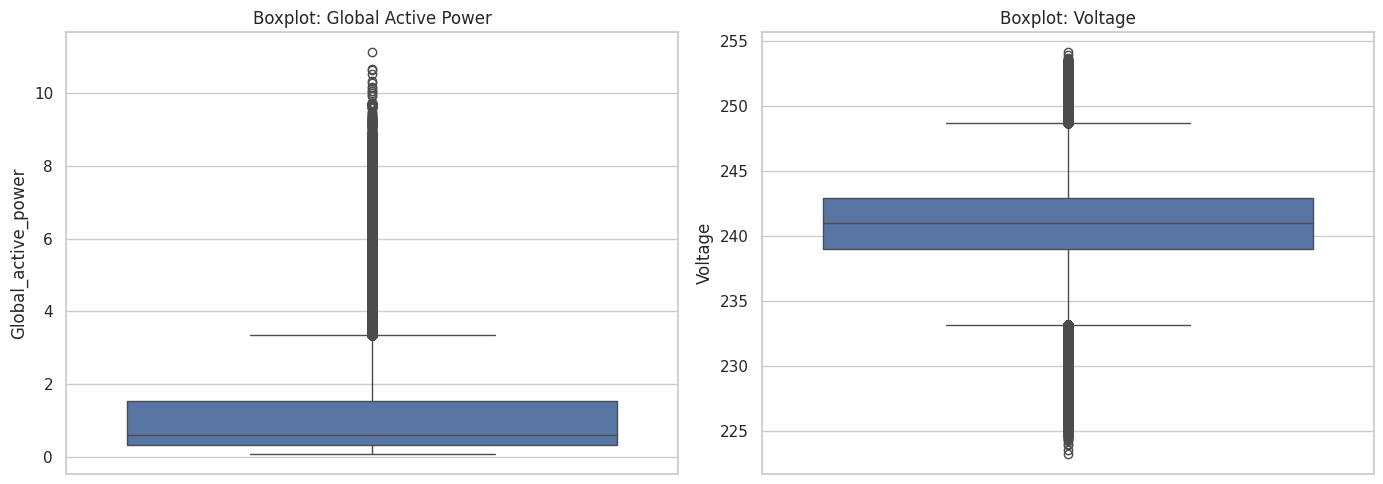

In [7]:
sns.set(style="whitegrid")
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
sns.boxplot(y=df['Global_active_power'])
plt.title('Boxplot: Global Active Power')

plt.subplot(1, 2, 2)
sns.boxplot(y=df['Voltage'])
plt.title('Boxplot: Voltage')

plt.tight_layout()
plt.show()

3. Strategy for handling missing value

In [8]:
df_clean = df.dropna()

print("Original shape:", df.shape)
print("After dropping NaNs:", df_clean.shape)

Original shape: (2075259, 8)
After dropping NaNs: (2049280, 8)


## 1.3 Temporal Aggregation & Multi-Frequency Views

1. Set Datetime as index

In [9]:
df_clean = df_clean.set_index('Datetime')
df_clean.index = pd.to_datetime(df_clean.index)  # Just to be sure

df_clean.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
Datetime,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0


2. Create aggregated DataFrames

In [10]:
df_hourly = df_clean.resample('h').mean()
df_daily = df_clean.resample('D').mean()
df_weekly = df_clean.resample('W').mean()


print("Original (per minute):", df_clean.shape)
print("Hourly:", df_hourly.shape)
print("Daily:", df_daily.shape)
print("Weekly:", df_weekly.shape)

Original (per minute): (2049280, 7)
Hourly: (34589, 7)
Daily: (1442, 7)
Weekly: (207, 7)


3. Line plot comparison (for Global Active Power)

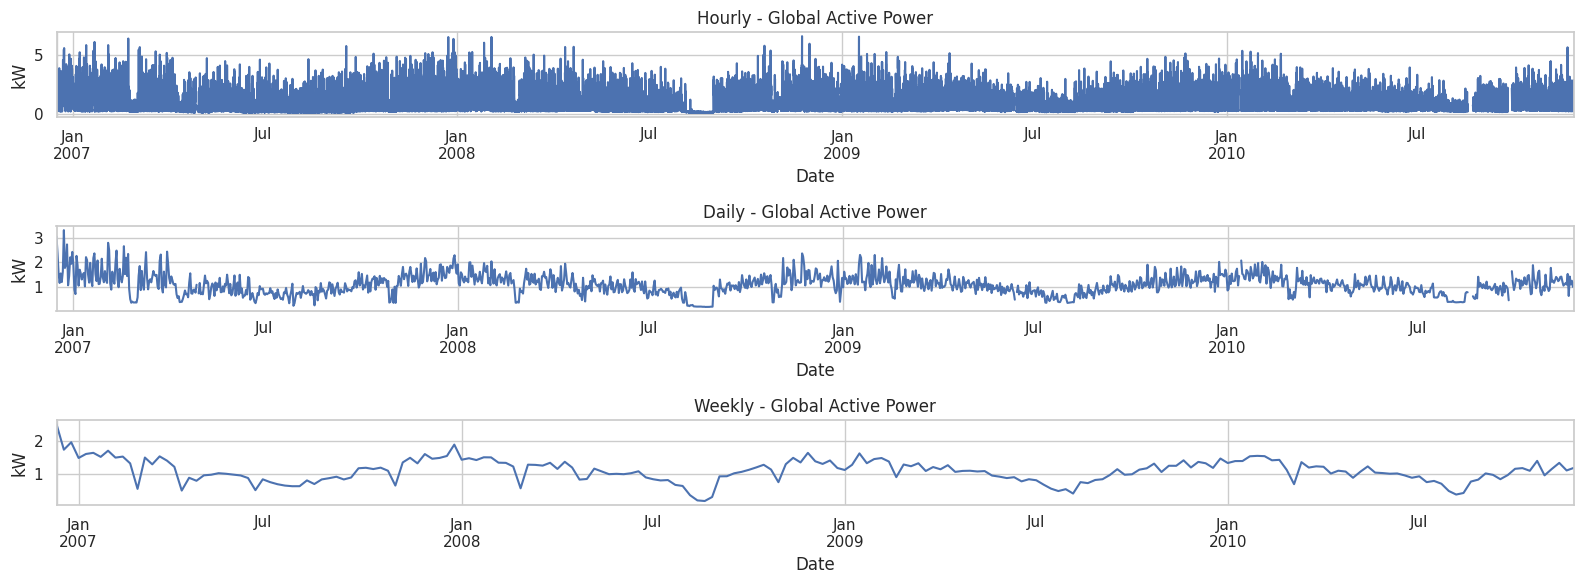

In [11]:
plt.figure(figsize=(16, 6))

# Hourly
plt.subplot(3, 1, 1)
df_hourly['Global_active_power'].plot()
plt.title("Hourly - Global Active Power")
plt.xlabel("Date")
plt.ylabel("kW")

# Daily
plt.subplot(3, 1, 2)
df_daily['Global_active_power'].plot()
plt.title("Daily - Global Active Power")
plt.xlabel("Date")
plt.ylabel("kW")

# Weekly
plt.subplot(3, 1, 3)
df_weekly['Global_active_power'].plot()
plt.title("Weekly - Global Active Power")
plt.xlabel("Date")
plt.ylabel("kW")


plt.tight_layout()
plt.show()

## 1.4 Time Series Decomposition & Autocorrelation

1. Decompose the daily time series

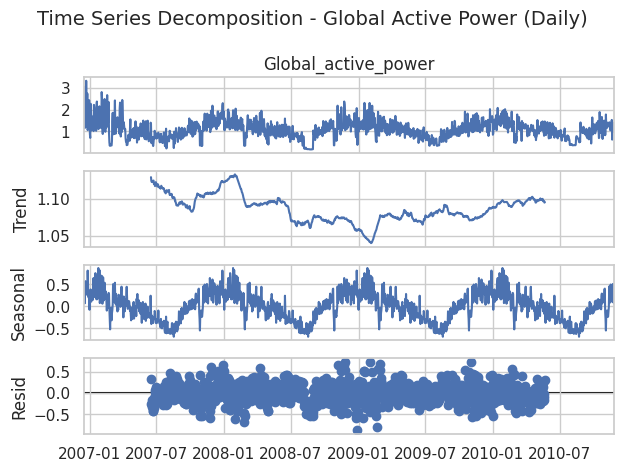

In [12]:
series = df_daily['Global_active_power']

series = series.dropna()

decomposition = seasonal_decompose(series, model='additive', period=365)

decomposition.plot()
plt.suptitle("Time Series Decomposition - Global Active Power (Daily)", fontsize=14)
plt.tight_layout()
plt.show()

2. Plot Autocorrelation

<Figure size 1000x500 with 0 Axes>

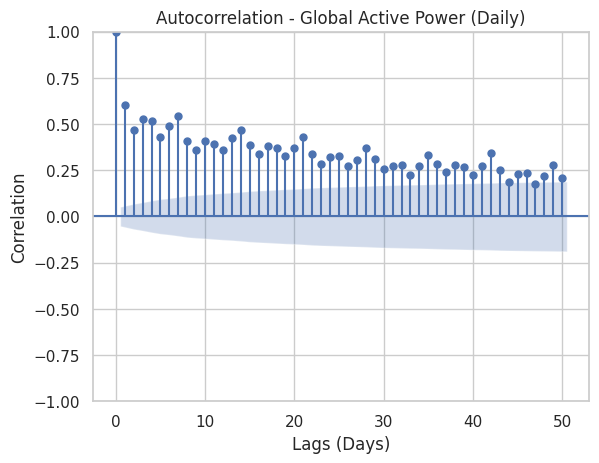

In [13]:
plt.figure(figsize=(10, 5))
plot_acf(series, lags=50)
plt.title("Autocorrelation - Global Active Power (Daily)")
plt.xlabel("Lags (Days)")
plt.ylabel("Correlation")
plt.show()

3. Plot Partial Autocorrelation (PACF)

<Figure size 1000x500 with 0 Axes>

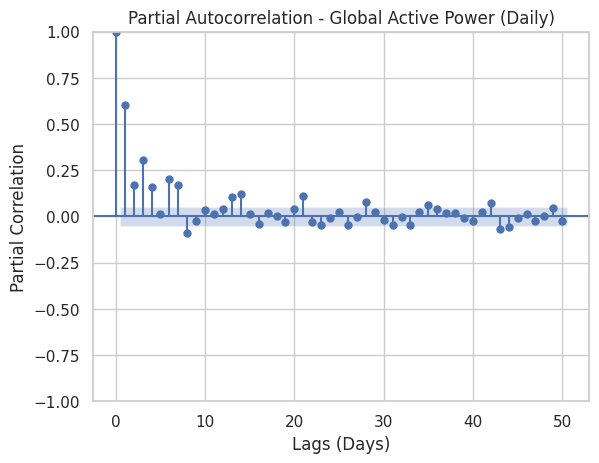

In [14]:
plt.figure(figsize=(10, 5))
plot_pacf(series, lags=50, method='ywm')
plt.title("Partial Autocorrelation - Global Active Power (Daily)")
plt.xlabel("Lags (Days)")
plt.ylabel("Partial Correlation")
plt.show()

> The PACF plot shows strong partial correlations at lag 1 and lag 2, indicating that the most recent 1–2 days significantly influence current energy consumption. This supports the inclusion of lag-1 and lag-2 features in the forecasting model.


# Phase 2: Feature Engineering & Forecasting

## 2.1 Feature Design

1. Time-based features

In [ ]:
df_features = df_daily.copy()
df_features = df_features.reset_index()

df_features['day'] = df_features['Datetime'].dt.day
df_features['month'] = df_features['Datetime'].dt.month
df_features['day_of_week'] = df_features['Datetime'].dt.dayofweek  # Monday=0, Sunday=6
df_features['is_weekend'] = df_features['day_of_week'].isin([5, 6]).astype(int)

df_features[['Datetime', 'day', 'month', 'day_of_week', 'is_weekend']].head()

,Datetime,day,month,day_of_week,is_weekend
0,2006-12-16,16,12,5,1
1,2006-12-17,17,12,6,1
2,2006-12-18,18,12,0,0
3,2006-12-19,19,12,1,0
4,2006-12-20,20,12,2,0


 2. Lag features (for target column: Global_active_power)

In [ ]:
df_features['lag_1'] = df_features['Global_active_power'].shift(1)
df_features['lag_2'] = df_features['Global_active_power'].shift(2)
df_features['lag_7'] = df_features['Global_active_power'].shift(7)

df_features[['Datetime', 'Global_active_power', 'lag_1', 'lag_2', 'lag_7']].head(10)

,Datetime,Global_active_power,lag_1,lag_2,lag_7
0,2006-12-16,3.053475,NaN,NaN,NaN
1,2006-12-17,2.354486,3.053475,NaN,NaN
2,2006-12-18,1.530435,2.354486,3.053475,NaN
3,2006-12-19,1.157079,1.530435,2.354486,NaN
4,2006-12-20,1.545658,1.157079,1.530435,NaN
5,2006-12-21,1.193758,1.545658,1.157079,NaN
6,2006-12-22,1.625929,1.193758,1.545658,NaN
7,2006-12-23,3.314851,1.625929,1.193758,3.053475
8,2006-12-24,1.770842,3.314851,1.625929,2.354486
9,2006-12-25,1.904944,1.770842,3.314851,1.530435


3. Rolling statistics

In [ ]:
df_features['rolling_mean_3'] = df_features['Global_active_power'].rolling(window=3).mean()
df_features['rolling_std_7'] = df_features['Global_active_power'].rolling(window=7).std()

df_features[['Datetime', 'Global_active_power', 'rolling_mean_3', 'rolling_std_7']].head(10)

,Datetime,Global_active_power,rolling_mean_3,rolling_std_7
0,2006-12-16,3.053475,NaN,NaN
1,2006-12-17,2.354486,NaN,NaN
2,2006-12-18,1.530435,2.312799,NaN
3,2006-12-19,1.157079,1.680667,NaN
4,2006-12-20,1.545658,1.411057,NaN
5,2006-12-21,1.193758,1.298832,NaN
6,2006-12-22,1.625929,1.455115,0.686102
7,2006-12-23,3.314851,2.044846,0.769050
8,2006-12-24,1.770842,2.237207,0.731863
9,2006-12-25,1.904944,2.330213,0.728174


## 2.2 Feature Selection

1. List all available features (columns)

In [ ]:
df_features.columns

Index(['Datetime', 'Global_active_power', 'Global_reactive_power', 'Voltage',
       'Global_intensity', 'Sub_metering_1', 'Sub_metering_2',
       'Sub_metering_3', 'day', 'month', 'day_of_week', 'is_weekend', 'lag_1',
       'lag_2', 'lag_7', 'rolling_mean_3', 'rolling_std_7'],
      dtype='object')

2. Drop rows with missing values (from lag/rolling)

In [ ]:
df_features = df_features.dropna()

3. Define target and feature columns

In [ ]:
target = 'Global_active_power'

features = [
    'Global_reactive_power', 'Voltage', 'Global_intensity',
    'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3',
    'day', 'month', 'day_of_week', 'is_weekend',
    'lag_1', 'lag_2', 'lag_7',
    'rolling_mean_3', 'rolling_std_7'
]

X = df_features[features]
y = df_features[target]

4. Show shapes of X and y

In [ ]:
print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (1391, 15)
y shape: (1391,)


## 2.3 Train/Test Split.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (1112, 15)
X_test shape: (279, 15)
y_train shape: (1112,)
y_test shape: (279,)


## 2.4 Model Training & Evaluation

### Linear Regression

In [ ]:
model_lr = LinearRegression()

* Train the model

In [ ]:
model_lr.fit(X_train, y_train)

LinearRegression()

* Predict on test set

In [ ]:
y_pred_lr = model_lr.predict(X_test)

* Performance

In [ ]:
mse_lr = mean_squared_error(y_test, y_pred_lr)
rmse_lr = np.sqrt(mse_lr)
mae_lr = mean_absolute_error(y_test, y_pred_lr)
r2_lr = r2_score(y_test, y_pred_lr)

print("Linear Regression Performance:")
print("MSE:", mse_lr)
print("RMSE:", rmse_lr)
print("MAE:", mae_lr)
print("R2 Score:", r2_lr)

Linear Regression Performance:
MSE: 2.721053228266126e-30
RMSE: 1.6495615260626462e-15
MAE: 1.3231152533615217e-15
R2 Score: 1.0


* actual vs predicted

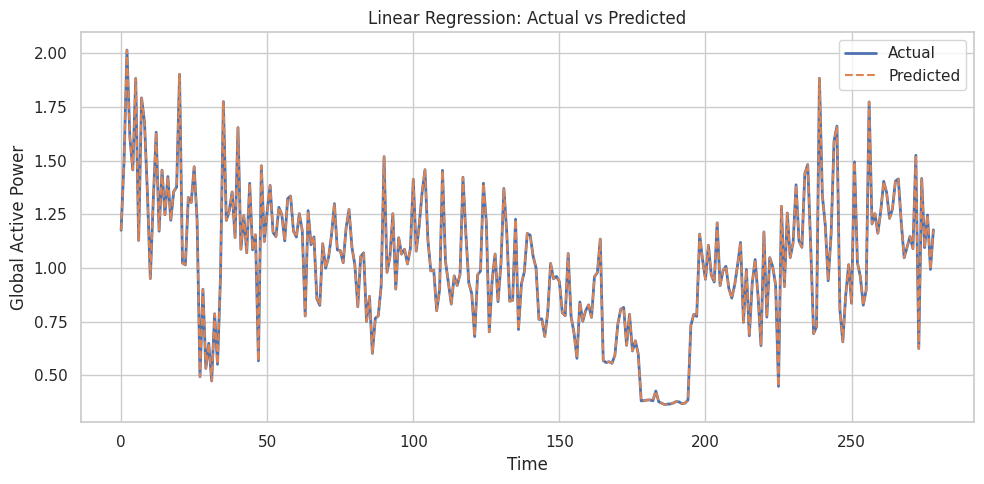

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(y_test.values, label='Actual', linewidth=2)
plt.plot(y_pred_lr, label='Predicted', linestyle='--')
plt.title('Linear Regression: Actual vs Predicted')
plt.xlabel('Time')
plt.ylabel('Global Active Power')
plt.legend()
plt.tight_layout()
plt.show()

### Random Forest

In [ ]:
model_rf = RandomForestRegressor(random_state=42)

* Train the model

In [ ]:
model_rf.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

* Predict on test set

In [ ]:
y_pred_rf = model_rf.predict(X_test)

* Performance

In [ ]:
mse_rf = mean_squared_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mse_rf)
mae_rf = mean_absolute_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print("Random Forest Performance:")
print("MSE:", mse_rf)
print("RMSE:", rmse_rf)
print("MAE:", mae_rf)
print("R2 Score:", r2_rf)

Random Forest Performance:
MSE: 0.00021915476113129153
RMSE: 0.01480387655755382
MAE: 0.01170802409568292
R2 Score: 0.9978992359702706


* actual vs predicted

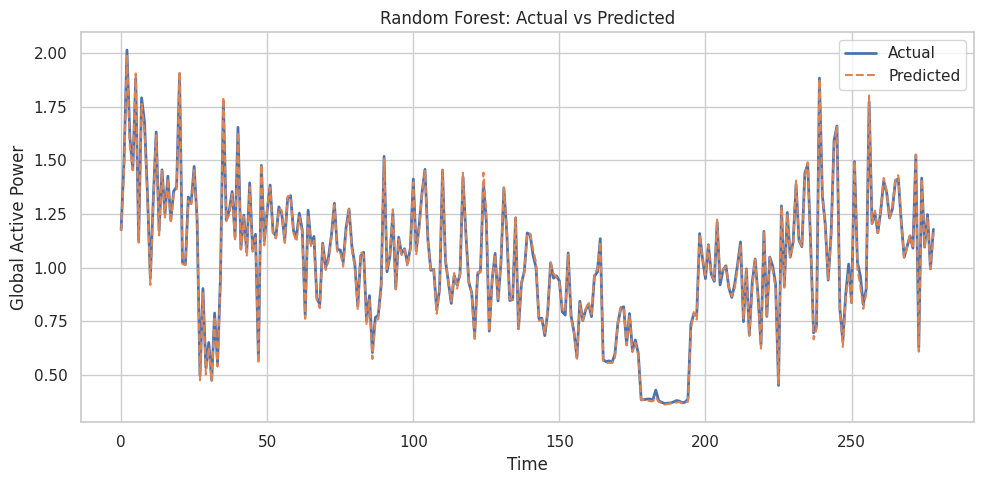

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(y_test.values, label='Actual', linewidth=2)
plt.plot(y_pred_rf, label='Predicted', linestyle='--')
plt.title('Random Forest: Actual vs Predicted')
plt.xlabel('Time')
plt.ylabel('Global Active Power')
plt.legend()
plt.tight_layout()
plt.show()

### XGBoost Regressor

In [ ]:
model_xgb = XGBRegressor(random_state=42)

* Train the model

In [ ]:
model_xgb.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=None,
             n_jobs=None, num_parallel_tree=None, ...)

* Predict on test set

In [ ]:
y_pred_xgb = model_xgb.predict(X_test)

* Performance

In [ ]:
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
rmse_xgb = np.sqrt(mse_xgb)
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)

print("XGBoost Performance:")
print("MSE:", mse_xgb)
print("RMSE:", rmse_xgb)
print("MAE:", mae_xgb)
print("R2 Score:", r2_xgb)

XGBoost Performance:
MSE: 0.00016892832086251553
RMSE: 0.012997242817710052
MAE: 0.010235279054074913
R2 Score: 0.9983806943630217


* Actual vs Predicted

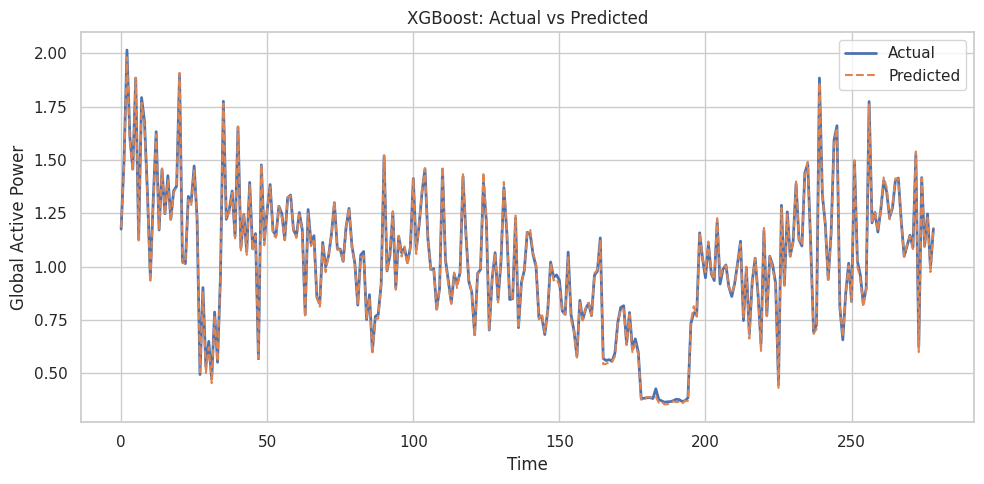

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(y_test.values, label='Actual', linewidth=2)
plt.plot(y_pred_xgb, label='Predicted', linestyle='--')
plt.title('XGBoost: Actual vs Predicted')
plt.xlabel('Time')
plt.ylabel('Global Active Power')
plt.legend()
plt.tight_layout()
plt.show()

# External Weather Data Integration

In [ ]:
start = "2006-12-16"
end = "2010-11-26"

url = (
    "https://archive-api.open-meteo.com/v1/era5?"
    f"latitude=31.95&longitude=35.93&start_date={start}&end_date={end}"
    "&daily=temperature_2m_max,temperature_2m_min,relative_humidity_2m_mean"
    "&timezone=UTC"
)

resp = requests.get(url)
data = resp.json()

weather = pd.DataFrame(data['daily'])
weather['date'] = pd.to_datetime(weather['time']).dt.date
weather = weather[['date','temperature_2m_max','relative_humidity_2m_mean']]

print(weather.head())

         date  temperature_2m_max  relative_humidity_2m_mean
0  2006-12-16                12.3                         37
1  2006-12-17                13.0                         30
2  2006-12-18                14.6                         35
3  2006-12-19                15.6                         38
4  2006-12-20                16.2                         45


In [ ]:
print(df_features.columns)

Index(['Datetime', 'Global_active_power', 'Global_reactive_power', 'Voltage',
       'Global_intensity', 'Sub_metering_1', 'Sub_metering_2',
       'Sub_metering_3', 'day', 'month', 'day_of_week', 'is_weekend', 'lag_1',
       'lag_2', 'lag_7', 'rolling_mean_3', 'rolling_std_7'],
      dtype='object')


In [ ]:
df_features['date'] = pd.to_datetime(df_features['Datetime']).dt.date

df_merged = pd.merge(df_features, weather, on='date', how='left')

print(df_merged[['date', 'temperature_2m_max', 'relative_humidity_2m_mean']].head())

         date  temperature_2m_max  relative_humidity_2m_mean
0  2006-12-23                12.1                         77
1  2006-12-24                11.5                         63
2  2006-12-25                12.2                         54
3  2006-12-26                10.5                         78
4  2006-12-27                 7.1                         89


In [ ]:
df_features = df_merged.copy()

In [ ]:
feature_columns = [
    'Global_active_power', 'Global_reactive_power', 'Voltage',
    'Global_intensity', 'Sub_metering_1', 'Sub_metering_3',
    'day', 'month', 'day_of_week', 'is_weekend',
    'lag_1', 'lag_2', 'lag_7', 'rolling_mean_3', 'rolling_std_7',
    'temperature_2m_max', 'relative_humidity_2m_mean'
]

X = df_features[feature_columns]
y = df_features['Sub_metering_2']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [ ]:
model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse:.2f}")
print(f"Mean Absolute Error: {mae:.2f}")
print(f"R² Score: {r2:.2f}")

Mean Squared Error: 1.15
Mean Absolute Error: 0.74
R² Score: 0.41


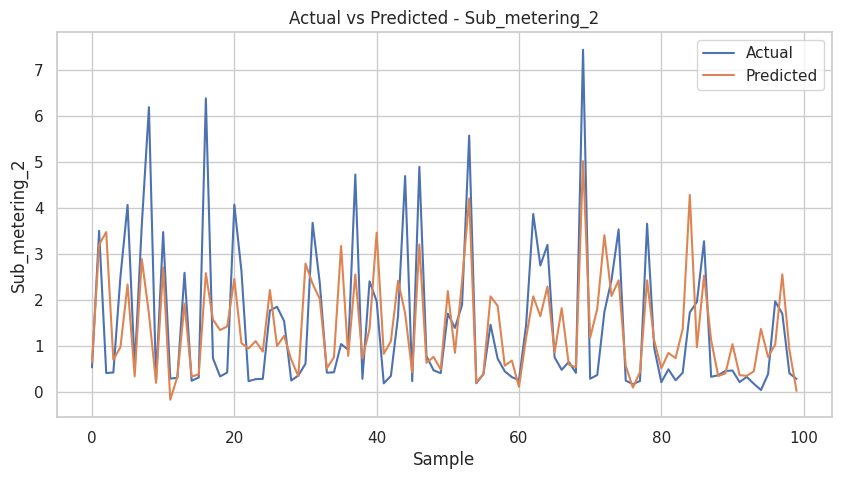

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(y_test.values[:100], label='Actual')
plt.plot(y_pred[:100], label='Predicted')
plt.title('Actual vs Predicted - Sub_metering_2')
plt.xlabel('Sample')
plt.ylabel('Sub_metering_2')
plt.legend()
plt.grid(True)
plt.show()

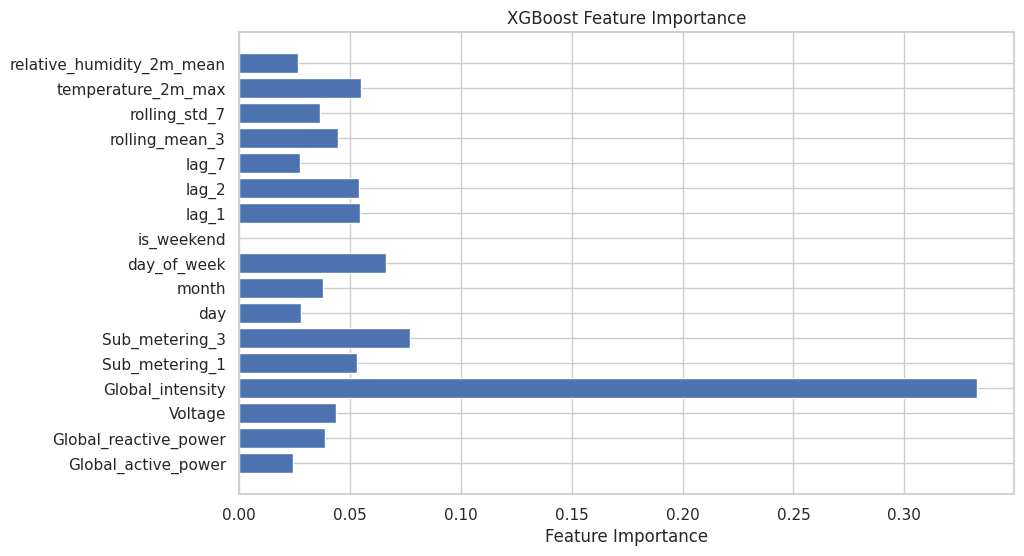

In [ ]:
importances = model.feature_importances_
features = X.columns

plt.figure(figsize=(10, 6))
plt.barh(features, importances)
plt.xlabel("Feature Importance")
plt.title("XGBoost Feature Importance")
plt.grid(True)
plt.show()

In [ ]:
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=100, random_state=42),
    "Support Vector Regressor": SVR()
}

results = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    results[name] = {
        "MSE": round(mse, 3),
        "MAE": round(mae, 3),
        "R²": round(r2, 3)
    }

In [ ]:
for model_name, metrics in results.items():
    print(f"\n {model_name}")
    for metric, value in metrics.items():
        print(f"{metric}: {value}")


 Linear Regression
MSE: 1.186
MAE: 0.779
R²: 0.396

 Random Forest
MSE: 1.192
MAE: 0.769
R²: 0.393

 Gradient Boosting
MSE: 1.205
MAE: 0.748
R²: 0.386

 Support Vector Regressor
MSE: 2.447
MAE: 0.932
R²: -0.247


# Uncertainty Estimation

In [ ]:
quantiles = [0.1, 0.5, 0.9]
models = {}

for q in quantiles:
    model = GradientBoostingRegressor(loss='quantile', alpha=q, n_estimators=100, max_depth=3, random_state=42)
    model.fit(X_train, y_train)
    models[q] = model

In [ ]:
y_lower = models[0.1].predict(X_test)
y_median = models[0.5].predict(X_test)
y_upper = models[0.9].predict(X_test)

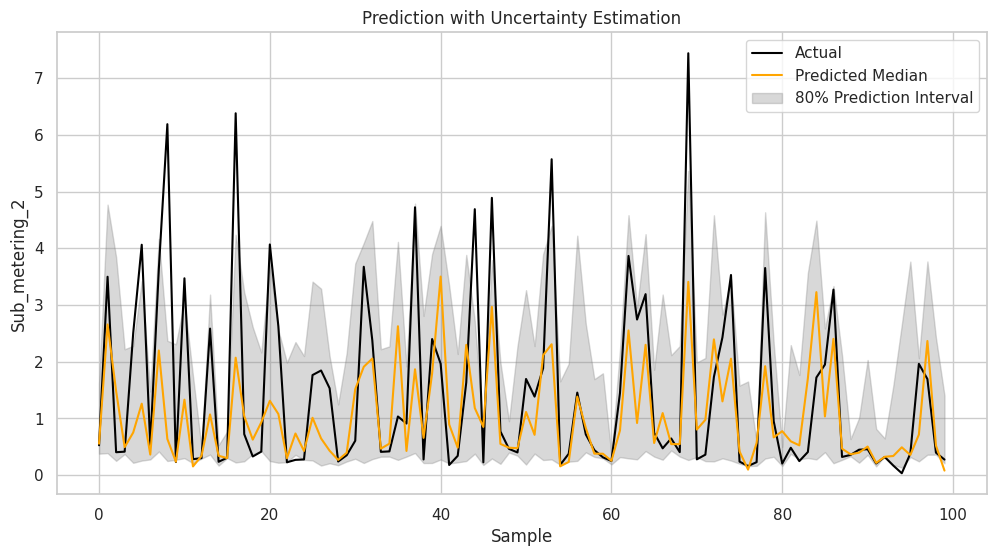

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(y_test.values[:100], label='Actual', color='black')
plt.plot(y_median[:100], label='Predicted Median', color='orange')
plt.fill_between(range(100), y_lower[:100], y_upper[:100], color='gray', alpha=0.3, label='80% Prediction Interval')

plt.title('Prediction with Uncertainty Estimation')
plt.xlabel('Sample')
plt.ylabel('Sub_metering_2')
plt.legend()
plt.grid(True)
plt.show()